# Scikit-image morphological active contours
We will test out two morphological active contour methods.

1. Morphological GAC
2. Morphological ACWE

This is based off of the following: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_morphsnakes.html

First, we import necessary packages.
Furthermore, change the following directory to the train set according to where you placed yours.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient)

DATA_DIR = "../data/vessels/train/"

Define a function to aid in sorting file names.

In [2]:
def order_func(x):
    name = os.path.splitext(x)[0]
    return int(name[:-2] + str(ord(name[-2]) % 97))

Define a function to store contour evolutions.

In [3]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

Now we can load the files into a numpy array.
We will end up with a $(96 \times 1024 \times 1024)$ array.

In [4]:
img_fnames = sorted(os.listdir(DATA_DIR + 'images'), key=order_func)
gtr_fnames = [f + '.npy' for f in img_fnames]
train_imgs = img_as_float(np.array([np.array(Image.open(DATA_DIR + "images/" + f)) for f in img_fnames]))
truth_imgs = img_as_float(np.array([np.load(DATA_DIR + "gt/" + f) for f in gtr_fnames]))

Next, we will just use the first training image for now.
For preprocessing, we will create an image using a Gaussian filter and another with an inverse Gaussian gradient (good for morphological GAC).


Text(0.5, 1.0, 'Inverse Gaussian Gradient')

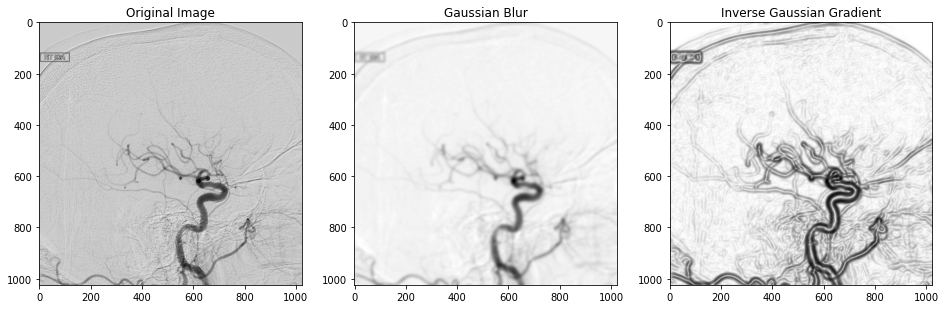

In [5]:
curr_image = train_imgs[0]  # just work on the first image
curr_truth = truth_imgs[0]
bimage = gaussian_filter(curr_image, sigma=5)
gimage = inverse_gaussian_gradient(curr_image)

fig1, axes1 = plt.subplots(1, 3, figsize=(16, 8))
ax1 = axes1.flatten()

ax1[0].imshow(curr_image, cmap='gray')
ax1[0].set_title('Original Image')

ax1[1].imshow(bimage, cmap='gray')
ax1[1].set_title('Gaussian Blur')

ax1[2].imshow(gimage, cmap='gray')
ax1[2].set_title('Inverse Gaussian Gradient')

Finally, we can use the library functions to compute the contours (they evolution is stored in case anyone wants to visualize this).
As you can see, for our purposes neither of these contours are very useful since all they do is contract and obtain the edge of the segmented object.
Still, maybe we can use one of these techniques in a useful way.

Overall, MACWE works much better for our purposes still. MGAC seems to need much more tuning of the parameters, particularly the balloon and threshold parameter seems sensitive from test runs. I plan to explore some more image processing techniques for both these methods.

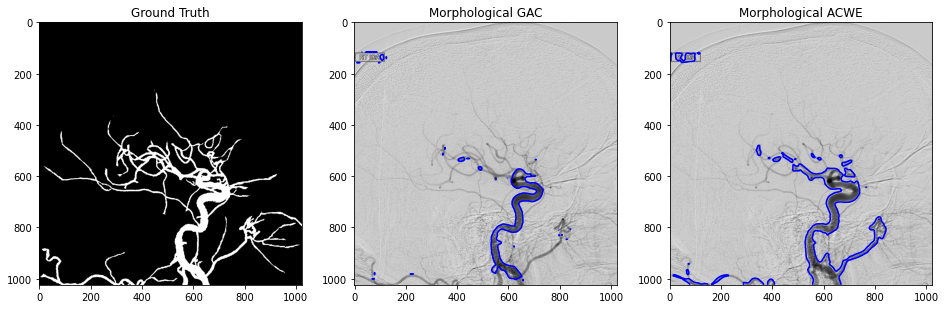

In [6]:
# Initial level set
init_ls = np.zeros(gimage.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolutions = [], []
callback1 = store_evolution_in(evolutions[0])
callback2 = store_evolution_in(evolutions[1])
# Morphological GAC
mgac = morphological_geodesic_active_contour(gimage, 750, init_ls.copy(),
                                             smoothing=1, balloon=-1.0,
                                             threshold=0.7,
                                             iter_callback=callback1)

# Morphological ACWE
macwe = morphological_chan_vese(bimage, 750, init_level_set=init_ls.copy(), smoothing=2,
                                iter_callback=callback2)

fig2, axes2 = plt.subplots(1, 3, figsize=(16, 8))
ax2 = axes2.flatten()

ax2[0].imshow(curr_truth, cmap='gray')
ax2[0].set_title('Ground Truth')

ax2[1].imshow(curr_image, cmap='gray')
ax2[1].set_title('Morphological GAC')
ax2[1].contour(mgac, [0.5], colors='b')

ax2[2].imshow(curr_image, cmap='gray')
ax2[2].set_title('Morphological ACWE')
ax2[2].contour(macwe, [0.5], colors='b')
